In [1]:
"""
air_inflow: 공기 흡입 유량 (^3/min)
air_end_temp: 공기 말단 온도 (°C)
out_pressure: 토출 압력 (Mpa)
motor_current: 모터 전류 (A)
motor_rpm: 모터 회전수 (rpm)
motor_temp: 모터 온도 (°C)
motor_vibe: 모터 진동 (mm/s)
type: 설비 번호

설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
설비 번호 1: 20HP
설비 번호 2: 10HP
설비 번호 3: 50HP
"""

'\nair_inflow: 공기 흡입 유량 (^3/min)\nair_end_temp: 공기 말단 온도 (°C)\nout_pressure: 토출 압력 (Mpa)\nmotor_current: 모터 전류 (A)\nmotor_rpm: 모터 회전수 (rpm)\nmotor_temp: 모터 온도 (°C)\nmotor_vibe: 모터 진동 (mm/s)\ntype: 설비 번호\n\n설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)\n설비 번호 1: 20HP\n설비 번호 2: 10HP\n설비 번호 3: 50HP\n'

In [173]:
import warnings

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler

from src.features import build_features

warnings.filterwarnings(action='ignore')


In [174]:
df = pd.read_csv(r'data\raw\train_data.csv')
test = pd.read_csv(r'data\raw\test_data.csv')

df = build_features.add_air_flow_pressure(df)
test = build_features.add_air_flow_pressure(test)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)
test_scaled = scaler.transform(test)

train = pd.DataFrame(data_scaled, columns=df.columns)
test = pd.DataFrame(test_scaled, columns=df.columns)

In [175]:
train = train.drop("type", axis=1)
test = test.drop("type", axis=1)

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 데이터 로드

# PCA 객체 생성
pca = PCA(n_components=2)
# pca.fit(train)

# var_ratio = pca.explained_variance_ratio_
# cum_var_ratio = np.cumsum(var_ratio)

# print(var_ratio)
# print(cum_var_ratio)
# plt.plot(range(1, len(var_ratio) + 1), var_ratio, 'b-o', label='Explained Variance Ratio')
# plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, 'r-o', label='Cumulative Explained Variance Ratio')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Variance Ratio')
# plt.legend()
# plt.show()


In [177]:
train_pca = pca.fit_transform(train)
test_pca = pca.transform(test)

In [178]:
# 모델 학습 및 이상치 탐지
model = IsolationForest(n_estimators=2000, contamination=0.03, random_state=42)
# model = EllipticEnvelope(support_fraction=0.995, contamination=0.01)
print(model)
model.fit(train_pca)
test["anomaly"] = model.predict(test_pca)


test.anomaly.value_counts()


# model.fit(train.drop("type", axis=1))
# test["anomaly"] = model.predict(test.drop("type", axis=1))


# test.anomaly.value_counts()

IsolationForest(contamination=0.03, n_estimators=2000, random_state=42)


 1    7222
-1     167
Name: anomaly, dtype: int64

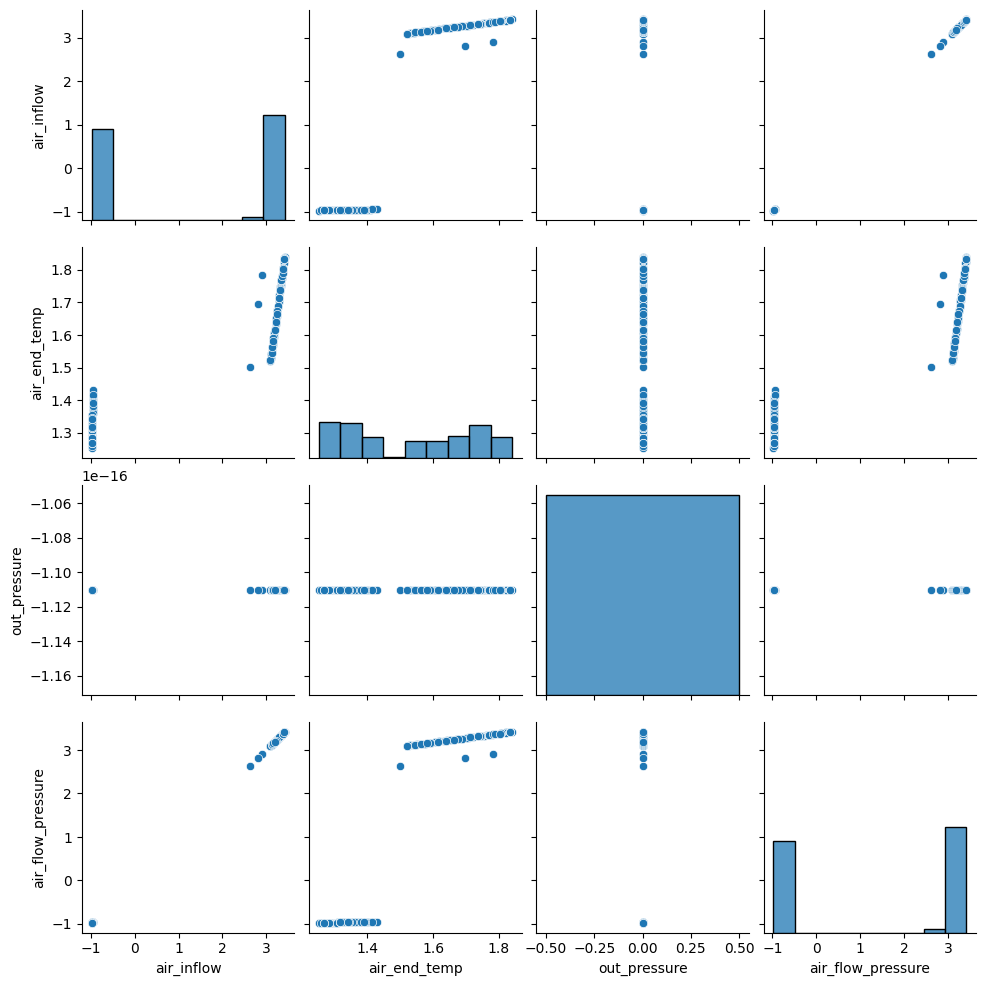

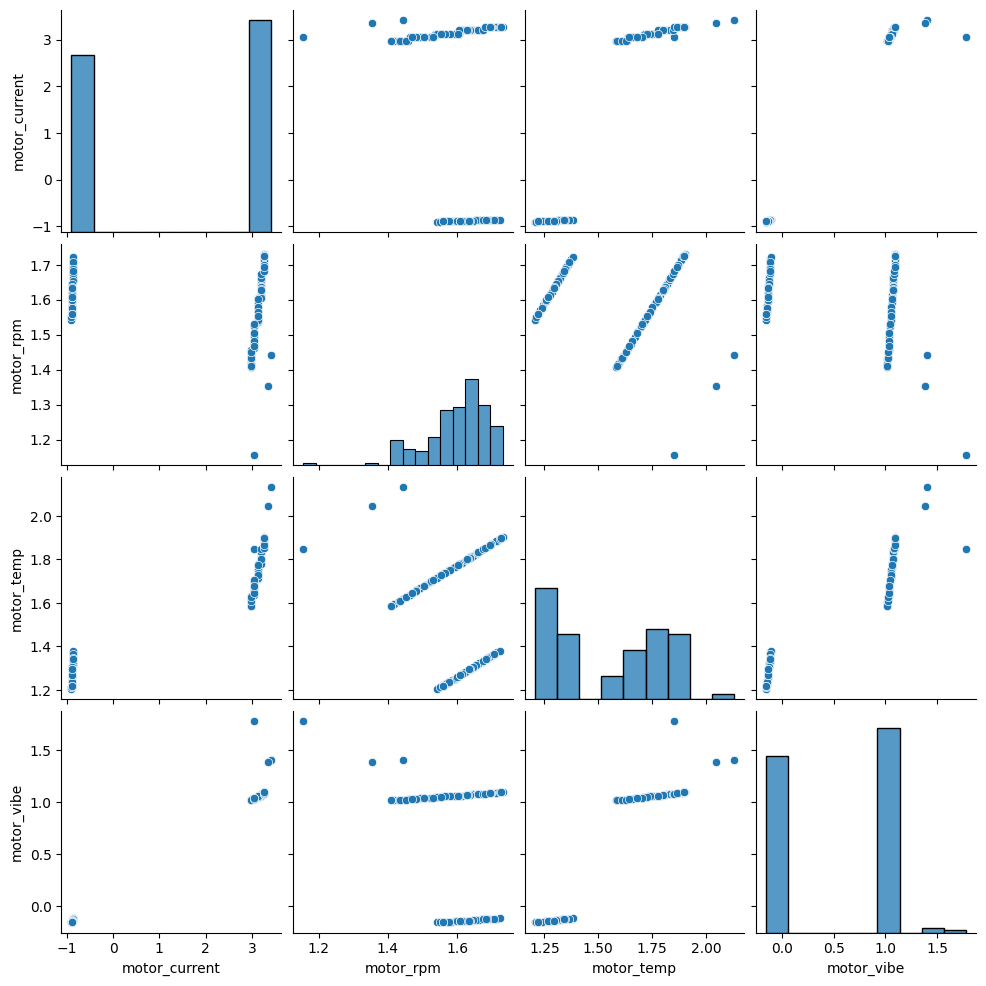

In [179]:
import seaborn as sns

test1 = test[test["anomaly"] == -1]
sns.pairplot(test1[['air_inflow', 'air_end_temp', 'out_pressure', "air_flow_pressure"]])
sns.pairplot(test1[['motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']])


In [17]:
df = pd.read_csv(r'data\raw\train_data.csv')
test = pd.read_csv(r'data\raw\test_data.csv')

df = build_features.add_motor_hp(df)
df = build_features.add_air_flow_pressure(df)
df = build_features.add_motor_vibe_freq(df)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)
data_scaled_df = pd.DataFrame(data_scaled, columns=df.columns)

test = build_features.add_motor_hp(test)
test = build_features.add_air_flow_pressure(test)
test = build_features.add_motor_vibe_freq(test)


train, val = train_test_split(data_scaled_df, test_size=0.3, shuffle=True, random_state=42)

# 모델 학습 및 이상치 탐지
model = EllipticEnvelope(contamination=0.09)
model.fit(train.drop("type", axis=1))

val["anomaly"] = model.predict(val.drop("type", axis=1))
test["anomaly"] = model.predict(test.drop("type", axis=1))

y_true = val["type"].apply(lambda x: 1 if x == "anomaly" else 0)
y_pred = val["anomaly"].apply(lambda x: 1 if x == -1 else 0)
print(y_pred.value_counts())
macro_f1 = f1_score(y_true, y_pred, average="macro")
macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")

print("Macro F1-score: {:.4f}".format(macro_f1))
print("Macro Precision: {:.4f}".format(macro_precision))
print("Macro Recall: {:.4f}".format(macro_recall))

test.anomaly.value_counts()

0    678
1     61
Name: anomaly, dtype: int64
Macro F1-score: 0.4785
Macro Precision: 0.5000
Macro Recall: 0.4587


-1    7389
Name: anomaly, dtype: int64

In [180]:
test_score = test.copy()
test_score["anomaly"] = test_score["anomaly"].apply(lambda x: 0 if x > 0 else 1)


submission = pd.read_csv(r'data\raw\answer_sample.csv')
submission["label"] = test_score["anomaly"]
print(submission.label.value_counts())
submission.to_csv(r'data\submission\submission.csv', index=False)

0    7222
1     167
Name: label, dtype: int64
